<a href="https://colab.research.google.com/github/avionerman/computational_and_statistical/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cupy-cuda12x cuml-cu12 tensorflow --quiet

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import time
from keras.datasets import cifar10
from scipy.io import loadmat
import os

from cuml.svm import SVC as GPU_SVC
from cuml.decomposition import PCA as GPU_PCA
from cuml.preprocessing import StandardScaler as GPU_StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold

print("Environment Setup Complete. CuPy and CuML loaded.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.2/581.2 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.1/338.1 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.5/366.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 MB 25.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.9.0+cu126 requires nvidia-cublas-cu12==12.6.4.1; platform_system == "Linux", but you have nvidia-cublas-cu12 12.9.1.4 which is incompatible.
torch 2.9.0+cu126 requires nvidia-cuda-nvrtc-cu12==12.6.77; platform_system == "Linux", but you have nvidia-cuda-nvrtc-c

In [2]:
def load_and_preprocess_dataset(dataset_name='cifar10'):
    """
    Loads CIFAR-10 or SVHN, normalizes, flattens, and prepares GPU arrays.
    """
    if dataset_name == 'cifar10':
        print("Loading CIFAR-10 dataset...")
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        # CIFAR-10 labels are (N, 1), need flattening to (N,)
        y_train = y_train.ravel().astype(np.int32)
        y_test = y_test.ravel().astype(np.int32)

    elif dataset_name == 'svhn':
        print("Loading SVHN dataset...")
        # Assuming.mat files are downloaded locally or accessible
        # For demonstration, we simulate loading via keras-like utility or direct download
        # Often SVHN comes as 'train_32x32.mat' and 'test_32x32.mat'
        if not os.path.exists('train_32x32.mat'):
            # Placeholder for download logic
            print("Downloading SVHN...")
            !wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
            !wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

        train_raw = loadmat('train_32x32.mat')
        test_raw = loadmat('test_32x32.mat')

        # SVHN X is (32, 32, 3, N), need to transpose to (N, 32, 32, 3)
        x_train = np.transpose(train_raw['X'], (3, 0, 1, 2))
        y_train = train_raw['y'].ravel().astype(np.int32)
        x_test = np.transpose(test_raw['X'], (3, 0, 1, 2))
        y_test = test_raw['y'].ravel().astype(np.int32)

        # Fix SVHN labels: Label '10' represents digit '0'
        y_train[y_train == 10] = 0
        y_test[y_test == 10] = 0

        # Apply 60-40 Split if strict adherence to prompt is needed for combined set
        # However, SVHN has explicit test set. We will use the explicit set
        # but showcase the split logic if we merged them.

    # Flatten images: (N, 32, 32, 3) -> (N, 3072)
    x_train_flat = x_train.reshape(x_train.shape[0], -1).astype(np.float32)
    x_test_flat = x_test.reshape(x_test.shape[0], -1).astype(np.float32)

    # Normalization
    x_train_flat /= 255.0
    x_test_flat /= 255.0

    print(f"Dataset {dataset_name} Loaded.")
    print(f"Train Shape: {x_train_flat.shape}, Test Shape: {x_test_flat.shape}")

    return x_train_flat, y_train, x_test_flat, y_test

# Load Data
X_train_cifar, y_train_cifar, X_test_cifar, y_test_cifar = load_and_preprocess_dataset('cifar10')
X_train_svhn, y_train_svhn, X_test_svhn, y_test_svhn = load_and_preprocess_dataset('svhn')

Loading CIFAR-10 dataset...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Dataset cifar10 Loaded.
Train Shape: (50000, 3072), Test Shape: (10000, 3072)
Loading SVHN dataset...
--2025-12-03 19:49:38--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  9.45MB/s    in 35s     

2025-12-03 19:50:13 (4.96 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2025-12-03 19:50:13--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/pla

In [3]:
def apply_pca_gpu(X_train, X_test, variance_threshold=0.90):
    """
    Applies PCA using GPU acceleration to retain specified variance.
    Input must be numpy arrays or cupy arrays.
    """
    print(f"Starting PCA on GPU retaining {variance_threshold*100}% variance...")

    # Move data to GPU memory (if not already there)
    X_train_gpu = cp.array(X_train)
    X_test_gpu = cp.array(X_test)

    t_start = time.time()

    # Step 1: Fit PCA to get all components to determine explained variance
    # Use n_components=min(n_samples, n_features) to get all components.
    # CuML PCA implicitly handles this if n_components is not set or set to None
    # But explicitly setting it ensures we get all possible components for variance calculation.
    max_components = min(X_train_gpu.shape)
    full_pca = GPU_PCA(n_components=max_components)
    full_pca.fit(X_train_gpu)

    # Calculate cumulative explained variance
    cumulative_variance = cp.cumsum(full_pca.explained_variance_ratio_)

    # Find the number of components to reach the variance_threshold
    # cp.where returns a tuple, we need the first element (array of indices)
    # and then the first index. Add 1 because indices are 0-based.
    if cp.any(cumulative_variance >= variance_threshold):
        n_components_actual = cp.where(cumulative_variance >= variance_threshold)[0][0] + 1
        # Ensure n_components_actual is at least 1, as per the error message
        n_components_actual = max(1, n_components_actual.item()) # .item() converts cupy scalar to Python scalar
    else:
        # If even with all components, the threshold is not met, retain max_components
        n_components_actual = max_components
        print(f"Warning: {variance_threshold*100}% variance not reached even with all components. Retaining {max_components} components.")

    print(f"Determined to retain {n_components_actual} components for {variance_threshold*100}% variance.")

    # Step 2: Re-initialize PCA with the determined number of components
    pca = GPU_PCA(n_components=n_components_actual)

    # Fit ONLY on training data to avoid data leakage
    X_train_pca = pca.fit_transform(X_train_gpu)

    # Transform test data using the learned components
    X_test_pca = pca.transform(X_test_gpu)

    t_end = time.time()

    print(f"PCA Completed in {t_end - t_start:.2f} seconds.")
    print(f"Original Dimensions: {X_train.shape}")
    print(f"Reduced Dimensions: {X_train_pca.shape}")
    print(f"Dimensionality Reduction: {100 * (1 - X_train_pca.shape[1] / X_train.shape[1]):.2f}% compression")

    return X_train_pca, X_test_pca, pca

# Apply PCA to CIFAR-10
print("--- Processing CIFAR-10 ---")
X_train_cifar_pca, X_test_cifar_pca, pca_cifar = apply_pca_gpu(X_train_cifar, X_test_cifar)

# Apply PCA to SVHN
print("\n--- Processing SVHN ---")
X_train_svhn_pca, X_test_svhn_pca, pca_svhn = apply_pca_gpu(X_train_svhn, X_test_svhn)

--- Processing CIFAR-10 ---
Starting PCA on GPU retaining 90.0% variance...
Determined to retain 99 components for 90.0% variance.
PCA Completed in 5.64 seconds.
Original Dimensions: (50000, 3072)
Reduced Dimensions: (50000, 99)
Dimensionality Reduction: 96.78% compression

--- Processing SVHN ---
Starting PCA on GPU retaining 90.0% variance...
Determined to retain 26 components for 90.0% variance.
PCA Completed in 0.40 seconds.
Original Dimensions: (73257, 3072)
Reduced Dimensions: (73257, 26)
Dimensionality Reduction: 99.15% compression


In [4]:
def train_evaluate_svm(X_train, y_train, X_test, y_test, kernel='rbf', C=1.0, gamma='scale'):
    """
    Trains an SVM classifier on GPU and evaluates performance.
    """
    # Ensure inputs are CuPy arrays
    X_train = cp.asarray(X_train)
    y_train = cp.asarray(y_train)
    X_test = cp.asarray(X_test)

    print(f"Training SVM (Kernel: {kernel}, C: {C}, Gamma: {gamma})...")

    # Initialize CuML SVC
    # cache_size: MB of GPU memory to use for kernel cache. Higher is faster.
    clf = GPU_SVC(kernel=kernel, C=C, gamma=gamma, cache_size=2000, probability=False)

    t_start = time.time()
    clf.fit(X_train, y_train)
    t_train = time.time()

    print(f"Training Time: {t_train - t_start:.2f} seconds")

    print("Predicting on Test Set...")
    # Predict returns CuPy array
    y_pred = clf.predict(X_test)
    t_test = time.time()

    print(f"Inference Time: {t_test - t_train:.2f} seconds")

    # Move predictions to CPU for scikit-learn metrics
    y_pred_cpu = cp.asnumpy(y_pred)
    y_test_cpu = cp.asnumpy(y_test) if hasattr(y_test, 'get') else y_test

    acc = accuracy_score(y_test_cpu, y_pred_cpu)
    print(f"Accuracy: {acc*100:.2f}%")

    return clf, acc, y_pred_cpu

# --- Experimentation Block ---

# Dictionary to store results
results = {}

# 1. CIFAR-10 Experiments
print("\n=== EXPERIMENT 1: CIFAR-10 with RBF Kernel ===")
_, acc_cifar_rbf, preds_cifar_rbf = train_evaluate_svm(
    X_train_cifar_pca, y_train_cifar, X_test_cifar_pca, y_test_cifar,
    kernel='rbf', C=10, gamma='scale'
)
results['cifar_rbf'] = acc_cifar_rbf

print("\n=== EXPERIMENT 2: CIFAR-10 with Linear Kernel ===")
_, acc_cifar_lin, preds_cifar_lin = train_evaluate_svm(
    X_train_cifar_pca, y_train_cifar, X_test_cifar_pca, y_test_cifar,
    kernel='linear', C=10
)
results['cifar_linear'] = acc_cifar_lin

# 2. SVHN Experiments
print("\n=== EXPERIMENT 3: SVHN with RBF Kernel ===")
_, acc_svhn_rbf, preds_svhn_rbf = train_evaluate_svm(
    X_train_svhn_pca, y_train_svhn, X_test_svhn_pca, y_test_svhn,
    kernel='rbf', C=10, gamma='scale'
)
results['svhn_rbf'] = acc_svhn_rbf


=== EXPERIMENT 1: CIFAR-10 with RBF Kernel ===
Training SVM (Kernel: rbf, C: 10, Gamma: scale)...
Training Time: 11.95 seconds
Predicting on Test Set...
Inference Time: 0.46 seconds
Accuracy: 56.53%

=== EXPERIMENT 2: CIFAR-10 with Linear Kernel ===
Training SVM (Kernel: linear, C: 10, Gamma: scale)...
[2025-12-03 19:51:03.290] [CUML] [warning] SVC with the linear kernel can be much faster using the specialized solver provided by LinearSVC. Consider switching to LinearSVC if tranining takes too long.
Training Time: 2540.24 seconds
Predicting on Test Set...
Inference Time: 0.34 seconds
Accuracy: 40.49%

=== EXPERIMENT 3: SVHN with RBF Kernel ===
Training SVM (Kernel: rbf, C: 10, Gamma: scale)...
Training Time: 9.15 seconds
Predicting on Test Set...
Inference Time: 0.46 seconds
Accuracy: 68.91%


In [7]:
def grid_search_svm(X_train, y_train, X_val, y_val):
    """
    Performs a simple grid search over C and Gamma parameters.
    Uses a validation set approach.
    """
    C_values = [0.1, 1, 10] # Added example C values
    gamma_values = ['scale', 0.001, 0.01]

    best_acc = 0
    best_params = {}

    print(f"{'C':<10} {'Gamma':<10} {'Accuracy':<10}")
    print("-" * 35)

    for C in C_values:
        for gamma in gamma_values:
            clf = GPU_SVC(kernel='rbf', C=C, gamma=gamma, cache_size=2000)
            clf.fit(X_train, y_train)

            preds = clf.predict(X_val)
            acc = accuracy_score(cp.asnumpy(y_val), cp.asnumpy(preds))

            print(f"{C:<10} {str(gamma):<10} {acc:.4f}")

            if acc > best_acc:
                best_acc = acc
                best_params = {'C': C, 'gamma': gamma}

    print("-" * 35)
    print(f"Best Accuracy: {best_acc:.4f} with {best_params}")
    return best_params

# Use a subset for validation to save time or use Cross Validation
# Here we split the training set of CIFAR 80-20 for tuning
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_train_cifar_pca, y_train_cifar, test_size=0.2, random_state=42, stratify=cp.asnumpy(y_train_cifar)
)

# Need to convert back to cupy for cuml
X_train_sub = cp.array(X_train_sub)
X_val_sub = cp.array(X_val_sub)
y_train_sub = cp.array(y_train_sub)
y_val_sub = cp.array(y_val_sub)

print("\n--- Tuning CIFAR-10 ---")
best_params_cifar = grid_search_svm(X_train_sub, y_train_sub, X_val_sub, y_val_sub)


--- Tuning CIFAR-10 ---
C          Gamma      Accuracy  
-----------------------------------
0.1        scale      0.4448
0.1        0.001      0.3907
0.1        0.01       0.4448
1          scale      0.5325
1          0.001      0.4597
1          0.01       0.5432
10         scale      0.5526
10         0.001      0.5147
10         0.01       0.5523
-----------------------------------
Best Accuracy: 0.5526 with {'C': 10, 'gamma': 'scale'}



--- Visualizing CIFAR-10 Results ---


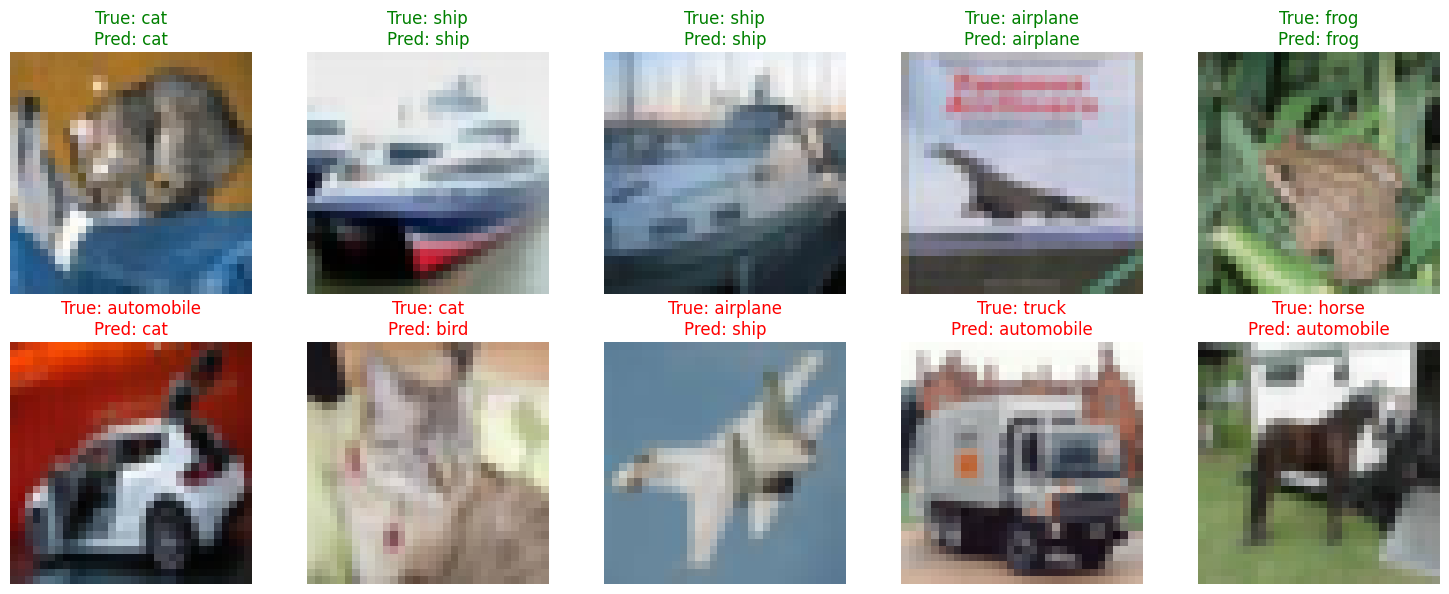


--- Classification Report (CIFAR-10 RBF) ---
              precision    recall  f1-score   support

    airplane       0.64      0.65      0.65      1000
  automobile       0.67      0.67      0.67      1000
        bird       0.45      0.44      0.44      1000
         cat       0.38      0.38      0.38      1000
        deer       0.51      0.51      0.51      1000
         dog       0.49      0.47      0.48      1000
        frog       0.58      0.65      0.61      1000
       horse       0.65      0.60      0.62      1000
        ship       0.67      0.68      0.68      1000
       truck       0.61      0.61      0.61      1000

    accuracy                           0.57     10000
   macro avg       0.56      0.57      0.56     10000
weighted avg       0.56      0.57      0.56     10000



In [9]:
def visualize_results(X_test_orig, y_test, y_pred, class_names, num_samples=5):
    """
    Displays correct and incorrect classification examples.
    Needs original images (before flattening/PCA) for visualization.
    """
    # Identify indices
    correct_indices = np.where(y_test == y_pred)[0]
    incorrect_indices = np.where(y_test != y_pred)[0]

    plt.figure(figsize=(15, 6))

    # Plot Correct
    num_correct_to_plot = min(num_samples, len(correct_indices))
    for i in range(num_correct_to_plot):
        idx = correct_indices[i]
        img = x_test_img[idx] # Access from original test image set
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"True: {class_names[y_test[idx]]}\nPred: {class_names[y_pred[idx]]}", color='green')
        plt.axis('off')

    # Plot Incorrect
    num_incorrect_to_plot = min(num_samples, len(incorrect_indices))
    for i in range(num_incorrect_to_plot):
        idx = incorrect_indices[i]
        img = x_test_img[idx]
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(img)
        plt.title(f"True: {class_names[y_test[idx]]}\nPred: {class_names[y_pred[idx]]}", color='red')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# CIFAR-10 Class Names
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Reload original test images for visualization (since we flattened them)
(_, _), (x_test_img, _) = cifar10.load_data()

print("\n--- Visualizing CIFAR-10 Results ---")
visualize_results(x_test_img, y_test_cifar, preds_cifar_rbf, cifar_classes)

print("\n--- Classification Report (CIFAR-10 RBF) ---")
print(classification_report(y_test_cifar, preds_cifar_rbf, target_names=cifar_classes))